# Convolutional VAE (CVAE)

In [1]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import pytorch_lightning as pl

import matplotlib.pyplot as plt
import numpy as np

import pmldiku
from pmldiku import data, vae, model_utils

%load_ext autoreload
%autoreload 1
%aimport pmldiku.data, pmldiku.vae, pmldiku.model_utils

In [2]:
torch.manual_seed(1)

cuda = True
batch_size = 128
epochs = 16
device_name = "cuda" if cuda else "cpu"

device = torch.device(device_name)
kwargs = {'num_workers': 4, 'pin_memory': device} 

In [3]:
# Val equals test here :)
train_loader = data.load_mnist(train=True).setup_data_loader(batch_size=batch_size, **kwargs)
val_loader = data.load_mnist(train=False).setup_data_loader(batch_size=batch_size, **kwargs)  

# Train model

In [5]:
vae_model = vae.CVAE(hidden_dim=2)
model = vae.LitVAE(vae=vae_model)
loss_callback = vae.VAELossCallback()
reconstruct_cb = vae.VAEImageReconstructionCallback(epochs)
callbacks = [loss_callback, reconstruct_cb]
trainer = pl.Trainer(max_epochs=epochs, devices=1, accelerator=device_name, callbacks=callbacks)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [6]:
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name | Type | Params
------------------------------
0 | vae  | CVAE | 96.7 K
------------------------------
96.7 K    Trainable params
0         Non-trainable params
96.7 K    Total params
0.387     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=16` reached.


array([74620.828125  , 21474.17773438, 20653.17773438, 20430.984375  ,
       20110.61328125, 20128.02734375, 19943.93554688, 19845.62109375,
       19800.66601562, 19795.81835938, 19705.41210938, 19608.32226562,
       19613.43945312, 19572.80859375, 19531.17382812, 19592.19140625,
       19571.60351562])

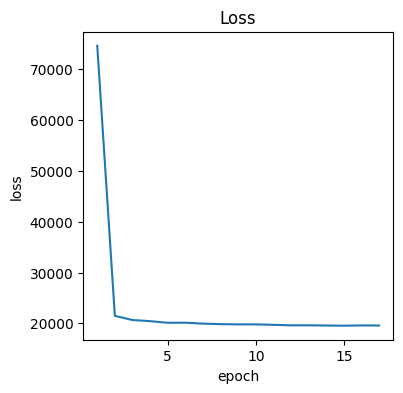

In [19]:
losses = np.array(loss_callback.val_loss)
model_utils.plot_loss(losses)
losses

# Reconstruction of model for each epoch of training

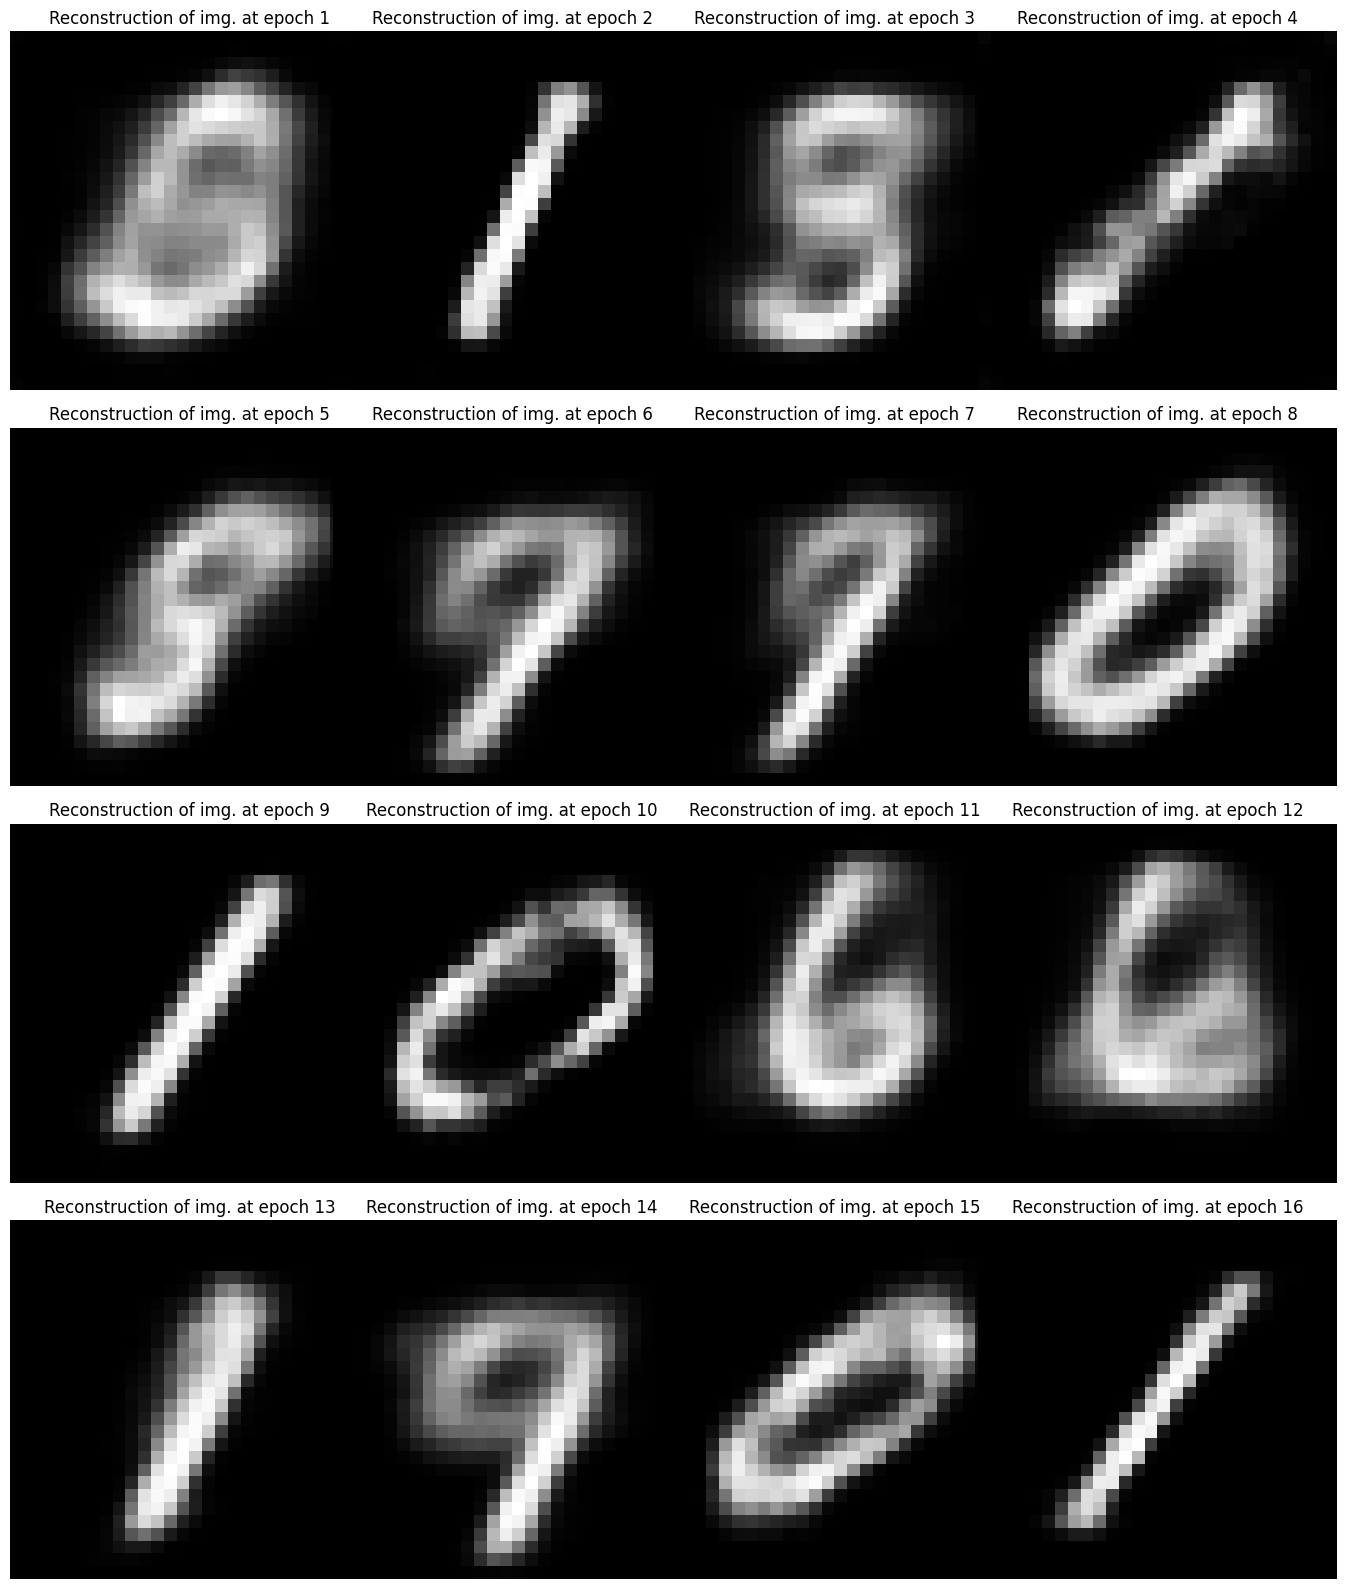

In [20]:
# Take first image of each batch of reconstructed images
images = reconstruct_cb.samples[:, 0, :, :]
model_utils.plot_image_reconstruction(images, num_cols=4, slim=20)

# Expected value in latent space for each number

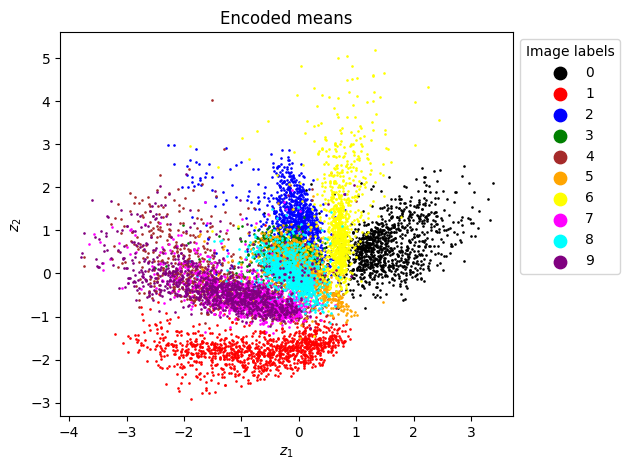

In [21]:
means_plot, labels = vae.encode_means(model.vae, val_loader)
plot_args = dict(title="Encoded means", xlabel=r"$z_1$", ylabel=r"$z_2$")
model_utils.plot_encoded(means_plot, labels, **plot_args)

# Reconstruction of equally spaced gaussian noise

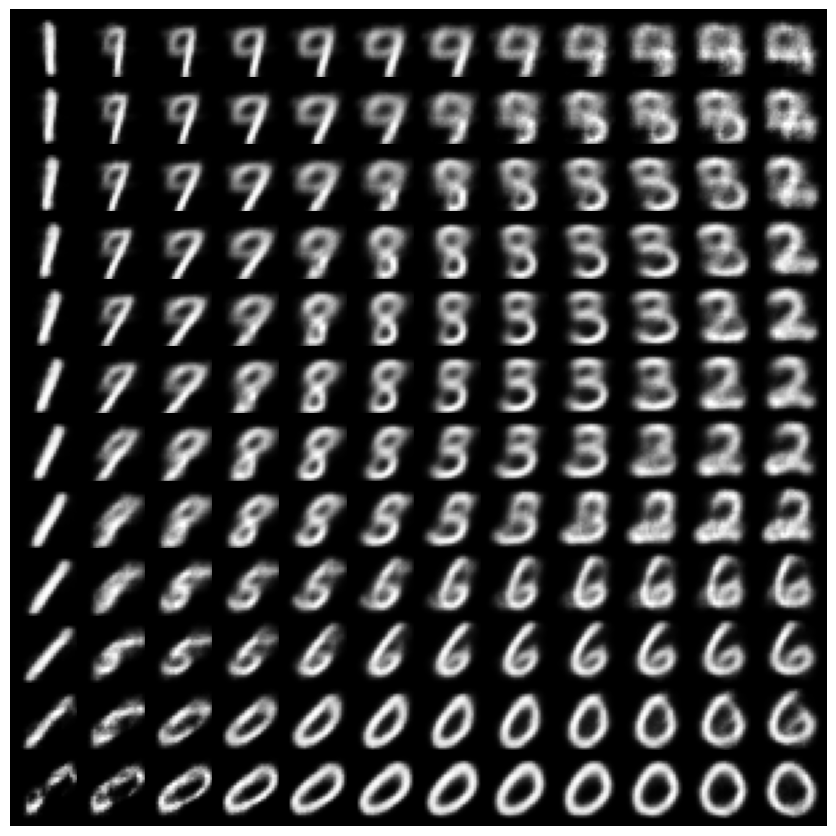

In [23]:
gauss_vals = model_utils.construct_gauss_grid(M=12)
decoded_imgs = model.vae.decode(gauss_vals).detach().numpy()
model_utils.plot_gauss_grid_imgs(decoded_imgs)

## Padding stuff

In [24]:
def same_padding(I, S, K):
    """How much padding to achieve same output as input dim"""
    num = I * (S - 1) - S + K
    P = num / 2
    return P

same_padding(7, 2, 3)

4.0

In [25]:
def conv2dt_output(S, N, K, P):
    """Computes outputdim of applying Conv2dTranspose"""
    return S * (N - 1) + K - 2 * P 

output1 = conv2dt_output(2, 7, 3, 1)
output2 = conv2dt_output(2, output1, 3, 1)
output3 = conv2dt_output(1, output2, 3, 0)
output1, output2, output3

(13, 25, 27)

In [26]:
# Unflatten
output_cv = torch.randn((2, 3136))
nn.Unflatten(dim=1, unflattened_size=[64, 7, 7])(output_cv).size()

torch.Size([2, 64, 7, 7])

In [27]:
vae_model.encode_cv_dim()
vae_model.img_dim_encoder, vae_model.total_dim_encoder

(7, 3136)